In [37]:
"""
In order to run the code as is, you will need scipy, pandas and tqdm installed 
(although tqdm is only needed for the progress bar, and pandas is only for the autocorrelation function)
All of these can be installed (on linux) from the command interface using 'pip'
""" 

import scipy.io as sio
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from gibbsrank import gibbs_sample
from eprank import eprank
import pandas
from cw2 import sorted_barplot
%matplotlib inline

We first need to load the data, stored in "tennis_data.mat". The data consists of an array, $W$ containing the names of each player, and an array, G, containing the results of all of the matches in the season. 

In [38]:
# set seed for reproducibility
np.random.seed(0)
# load data
data = sio.loadmat('tennis_data.mat')
# Array containing the names of each player
W = data['W']
# loop over array to format more nicely
for i, player in enumerate(W):
    W[i] = player[0]
# Array of size num_games x 2. The first entry in each row is the winner of game i, the second is the loser
G = data['G'] - 1
# Number of players
M = W.shape[0]
# Number of Games
N = G.shape[0]

# Gibbs sampling (This may take a minute)

In [39]:
# number of iterations
num_iters = 1100
# perform gibbs sampling, skill samples is an num_players x num_samples array
skill_samples = gibbs_sample(G, M, num_iters)#, random_nums)


100%|██████████| 1100/1100 [05:20<00:00,  3.43it/s]


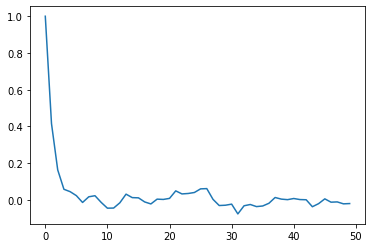

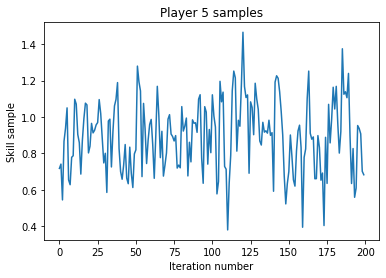

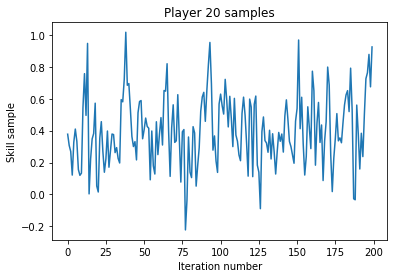

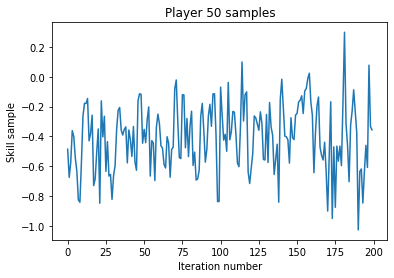

In [40]:
# Code for plotting the autocorrelation function for player p
p = 55
autocor = np.zeros(50)
for i in range(50):
    autocor[i]=pandas.Series.autocorr(pandas.Series(skill_samples[p,:]),lag=i)
plt.plot(autocor)
plt.show()

players = [5,20,50]
for player in players:
    plt.plot(skill_samples[player,:200])
    plt.title('Player '+str(player)+' samples')
    plt.xlabel('Iteration number')
    plt.ylabel('Skill sample')
    plt.show()

# EP ranking

[0.74497722 0.80255717 0.8261694  ... 1.45186447 1.45166113 1.45180449]


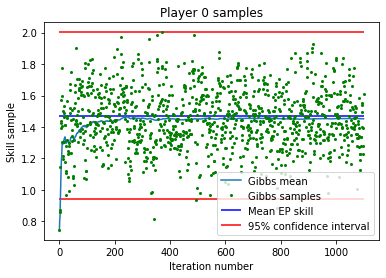

[0.71778194 0.7295807  0.66794085 ... 0.86869099 0.86864758 0.8687697 ]


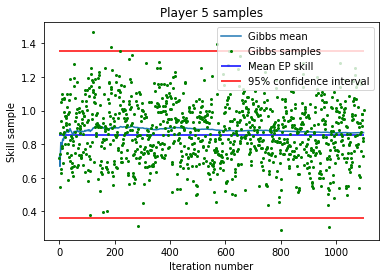

[0.37755493 0.3422856  0.31791839 ... 0.4128185  0.41290943 0.41283468]


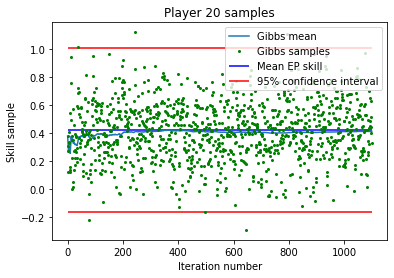

In [41]:
num_iters = 1000
# run message passing algorithm, returns mean and precision for each player
mean_player_skills, precision_player_skills = eprank(G, M, num_iters)
players = [0,5,20]

for player in players:
    gibbs_mean = np.zeros(1100)
    for i in range(len(gibbs_mean)):
        gibbs_mean[i] = np.mean(skill_samples[player, :i+1])
    print(gibbs_mean)
    plt.hlines(mean_player_skills[player], 0, 1100, color='blue', label='Mean EP skill')
    plt.hlines([mean_player_skills[player] + 3/np.sqrt(precision_player_skills[player]),mean_player_skills[player] - 3/np.sqrt(precision_player_skills[player])], 0, 1100, color='red', label='95% confidence interval')
    plt.plot(gibbs_mean, label='Gibbs mean')
    # plt.hlines(mean_player_skills[player] - 2/np.sqrt(precision_player_skills[player]), 0, 1100, color='red', label='Lower 95% confidence interval')
    plt.plot(skill_samples[player,:], 'o', color='green', markersize='2', label='Gibbs samples')
    plt.title('Player '+str(player)+' samples')
    plt.xlabel('Iteration number')
    plt.ylabel('Skill sample')
    plt.legend()
    plt.show()

## Part c

In [42]:
top_players = [15,0,4,10] # - indexes of top 4 players according to ATP ranking system in lectures
skill_prob = np.zeros((4,4))
win_prob = np.zeros((4,4))

for i,player_one in enumerate(top_players):
    for j,player_two in enumerate(top_players):
        if player_one != player_two:
            mean = mean_player_skills[player_one]-mean_player_skills[player_two]
            variance = 1/precision_player_skills[player_one] + 1/precision_player_skills[player_two]
            skill_prob[j, i] = 1-stats.norm.cdf(0, mean , np.sqrt(variance))
            win_prob[j, i] = 1-stats.norm.cdf(0, mean, np.sqrt(variance+1))
print(skill_prob)
print(win_prob)


[[0.         0.06017786 0.09111475 0.0146785 ]
 [0.93982214 0.         0.57282967 0.23348136]
 [0.90888525 0.42717033 0.         0.18916466]
 [0.9853215  0.76651864 0.81083534 0.        ]]
[[0.         0.34463299 0.36197304 0.28017427]
 [0.65536701 0.         0.51835186 0.42689   ]
 [0.63802696 0.48164814 0.         0.40912093]
 [0.71982573 0.57311    0.59087907 0.        ]]


## Part d

In [43]:
players = [0, 15]

player_mean = np.mean(skill_samples, axis=1)[players]
player_var = np.std(skill_samples, axis=1, ddof=1)[players]**2
print("Marginal player variances: ", player_var)

skill_prob = 1-stats.norm.cdf(0, player_mean[0]-player_mean[1] , np.sqrt(np.sum(player_var)))
print("Probability that player 0 has higher skill than player 15: ",skill_prob)

# TODO - complete approximation of joint skills?
covariance = np.cov(skill_samples[players,:])
print("Covariance matrix: \n", covariance)

count = np.count_nonzero(skill_samples[players[0],:]>skill_samples[players[1],:])
count_two = np.count_nonzero(skill_samples[players[0],:]<skill_samples[players[1],:])
print(count)
print(count_two)
print("Probability that player 0 has higher skill than player 15: ", count/(count+count_two))

Marginal player variances:  [0.03752262 0.04891708]
Probability that player 0 has higher skill than player 15:  0.06292994379995187
Covariance matrix: 
 [[0.03752262 0.00866539]
 [0.00866539 0.04891708]]
45
1055
Probability that player 0 has higher skill than player 15:  0.04090909090909091


## Part e

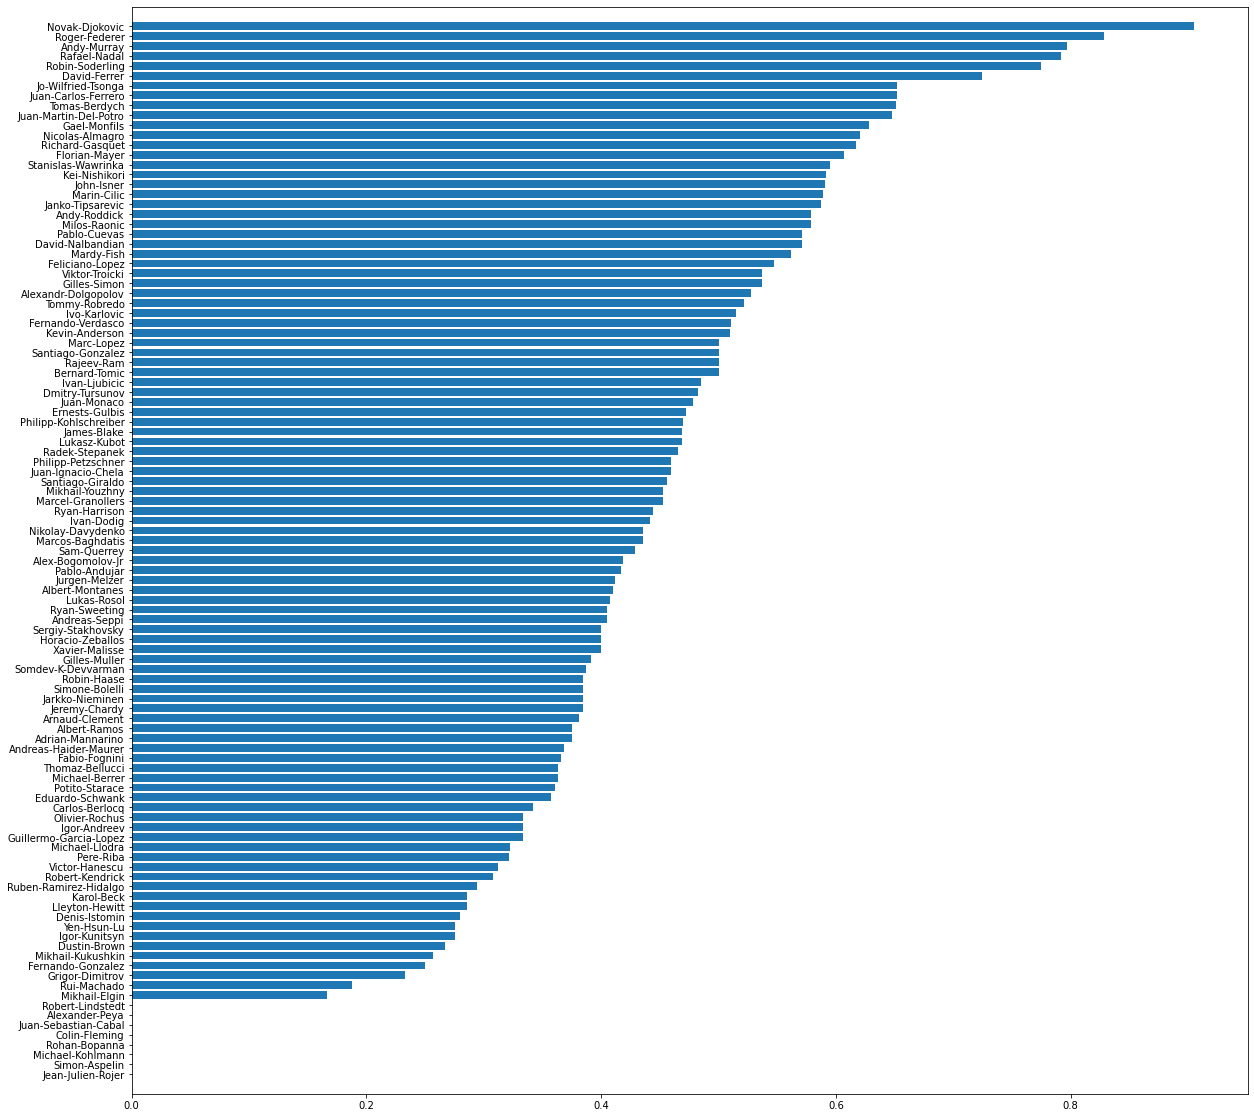

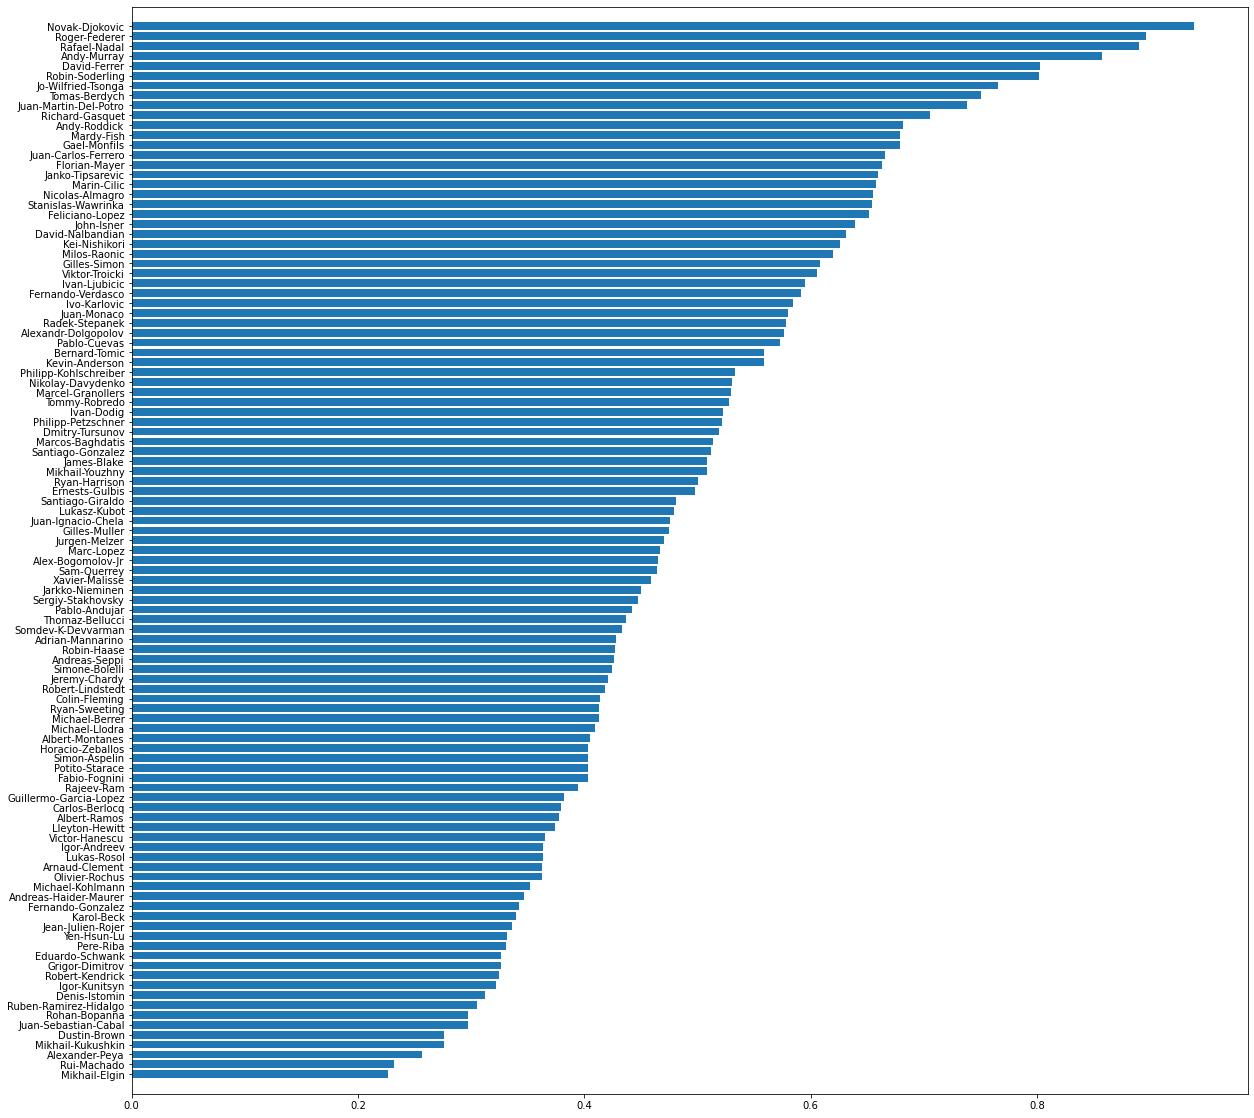

In [57]:
# 1 - empirical game outcome averages
no_wins = np.zeros(M)
no_losses = np.zeros(M)
outcome_average = np.zeros(M)
for i in range(M):
    no_wins[i] = np.count_nonzero(G[:,0]==i)
    no_losses[i] = np.count_nonzero(G[:,1]==i)
    outcome_average[i] = no_wins[i] / (no_wins[i]+no_losses[i])

sorted_barplot(outcome_average, W)

# 2 - Predictions based on Gibbs sampling

# 3 - Predictions based on message passing
win_prob = np.zeros((M,M))
for i in range(M):
    for j in range(M):
        if i != j:
            mean = mean_player_skills[i]-mean_player_skills[j]
            variance = 1/precision_player_skills[i] + 1/precision_player_skills[j]
            win_prob[j, i] = 1-stats.norm.cdf(0, mean, np.sqrt(variance+1))

message_passing_outcome = np.zeros(M)
for i in range(M):
    no_wins[i] = np.count_nonzero(win_prob[:,i]>0.5)
    message_passing_outcome[i] = no_wins[i] / 106
    # message_passing_outcome[i] = np.mean(win_prob[:,i])
# print(message_passing_outcome)
sorted_barplot(message_passing_outcome, W)